In [1]:
import math
import importlib
from typing import Literal

import torch
from torch import Tensor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ax import Client, RangeParameterConfig

from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy

from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

from src.model_generation import get_full_strategy
from src import GPVisualiser, ax_helper
from src.ax_helper import get_guess_coords


-0.0 -0.9874311636230129


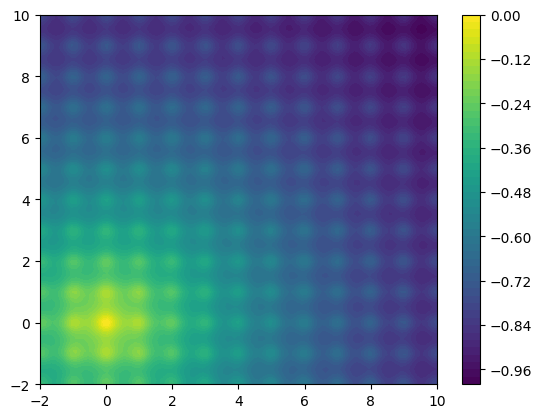

In [2]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1", "x2"]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    standardized = (ackley_grid-0.2434339681166695)/(19.3680592868830)
    return -standardized


import numpy as np
grid = np.linspace(-2, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
ackley_vals
print(ackley_vals.max(), ackley_vals.min())


plt.contourf(x1_grid, x2_grid, ackley_vals, levels=60, cmap="viridis")
plt.colorbar()

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

[INFO 09-23 12:14:20] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 0 with parameters {'x0': 10.0, 'x1': 10.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 1 with parameters {'x0': 94.676446, 'x1': 2.870178} using GenerationNode Sobol.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 2 with parameters {'x0': 8.890807, 'x1': 60.729594} using GenerationNode Sobol.
[INFO 09-23 12:14:20] ax.api.client: Generated new tri

   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0  94.676446   2.870178
2         2_0   8.890807  60.729594
3         3_0   1.809889   3.518247
4         4_0  19.622735  16.313447
5         5_0  13.451745   8.935274
6         6_0   1.484703  20.316103
7         7_0   3.956328   1.130307
8         8_0  37.832667  48.770648
9         9_0  44.858190   4.768471
10       10_0   4.776168  11.560480
11       11_0   1.318641   2.115613
12       12_0  12.164048  85.804914
13       13_0  31.554266   1.484259
14       14_0   2.858499  38.668954
15       15_0   6.035698   6.795752
16       16_0  63.127093  25.649069
17       17_0  74.724521   5.897675
18       18_0   6.768812  29.691293
19       19_0   2.537287   1.710555
20       20_0  26.539237  33.408732
21       21_0  10.604344   1.827501
22       22_0   1.129152  98.869682
23       23_0   5.553050   5.519390
24       24_0  51.221534  10.031668
25       25_0  31.817392   1.307935
26       26_0   3.512013  42

<Axes: xlabel='x0', ylabel='x1'>

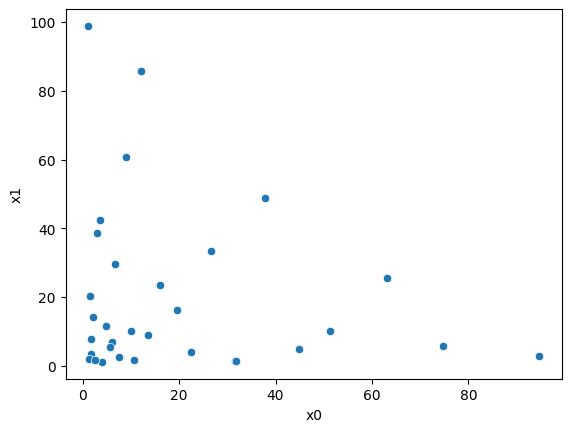

In [3]:
client = Client()

client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling = 'log',
        ) for i in range(len(dim_names))
    ],
)


client.configure_optimization(objective="-loss")

client.get_next_trials(max_trials=32)

coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

[INFO 09-23 12:14:20] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 0 with parameters {'x1': 50.5, 'x2': 50.5} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 1 with parameters {'x1': 99.418276, 'x2': 25.728587} using GenerationNode Sobol.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 2 with parameters {'x1': 29.517083, 'x2': 93.60499} using GenerationNode Sobol.
[INFO 09-23 12:14:20] ax.api.client: Generated new tr

<Axes: xlabel='x1', ylabel='x2'>

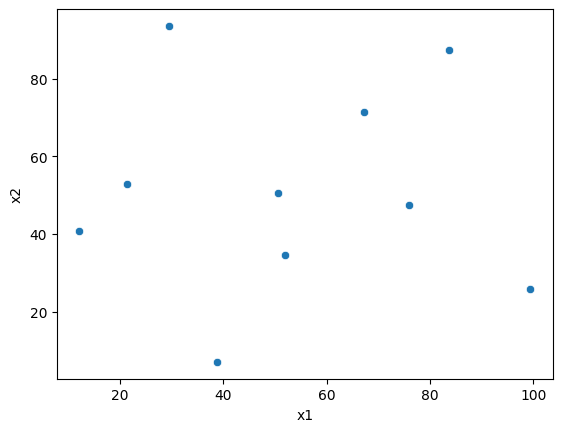

In [4]:
client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)

client.configure_optimization(objective="response")
client.get_next_trials(max_trials=10)

coords = get_guess_coords(client)

sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

[INFO 09-23 12:14:20] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0, 'x2': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 1 with parameters {'x1': 0.580873, 'x2': 6.135384} using GenerationNode Sobol.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 2 with parameters {'x1': 7.620716, 'x2': -0.539832} using GenerationNode Sobol.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'GP along x1'}, xlabel='x1', ylabel='response'>,
        <Axes: title={'center': 'GP along x2'}, xlabel='x2', ylabel='response'>],
       dtype=object))

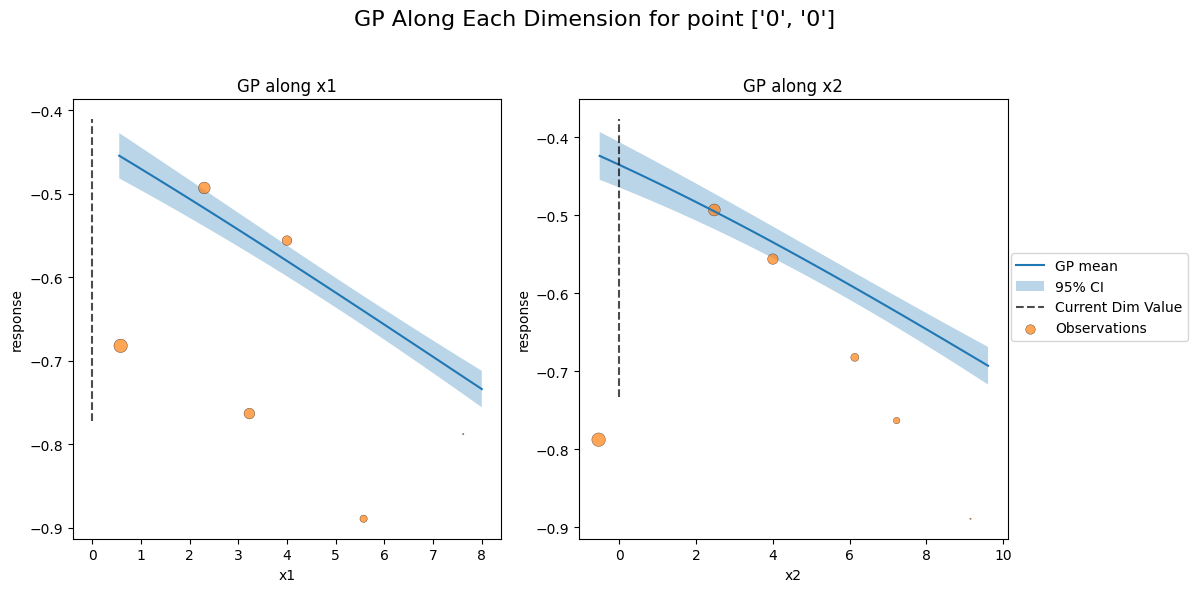

In [5]:
client = Client()

client.configure_experiment(parameters=range_parameters)


client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

obs = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, obs, dim_names, 'response', parameters)
plotter.plot_all([0,0])

In [6]:
obs

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,0.580873,6.135384,-0.682070
2,2_0,7.620716,-0.539832,-0.787757
3,3_0,5.573166,9.149573,-0.889147
4,4_0,2.300320,2.474357,-0.493036
5,5_0,3.226609,7.225462,-0.763189


# Custom Botorch model

### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [7]:
client = Client()
generation_strategy = get_full_strategy(gp=SingleTaskGP, acqf_class=qLogExpectedImprovement)
client.configure_experiment(parameters=range_parameters)

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)
client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

[INFO 09-23 12:14:20] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0, 'x2': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 1 with parameters {'x1': 8.910839, 'x2': -1.173986} using GenerationNode Sobol.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 2 with parameters {'x1': -0.195347, 'x2': 5.7693} using GenerationNode Sobol.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 3 with parameters {'x1': 2.533321, 'x2': 3.164091} using GenerationNode Sobol.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 4 with parameters {'x1': 6.157998, 'x2': 8.220819} using GenerationNode Sobol.
[INFO 09-23 12:14:20] ax.api.client: Generated new trial 5 with parameters {'x1': 4.77509, 'x2': 1.980719} using GenerationNode Sobol.
[INFO 09-23 12:14:20] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-23 12:14:20] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-23 12:14:20] ax.api.client: Trial 2 marked COM

[INFO 09-23 12:14:24] ax.api.client: Generated new trial 6 with parameters {'x1': -2.0, 'x2': 3.154566} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-23 12:14:24] ax.api.client: Generated new trial 7 with parameters {'x1': 10.0, 'x2': 3.153081} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-23 12:14:24] ax.api.client: Generated new trial 8 with parameters {'x1': -2.0, 'x2': 2.698925} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-23 12:14:24] ax.api.client: Generated new trial 9 with parameters {'x1': -2.0, 'x2': 3.434432} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-23 12:14:24] ax.api.client: Generated new trial 10 with parameters {'x1': 1.40482, 'x2': 3.303468} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-23 12:14:24] ax.api.client: Generated new trial 11 with parameters {'x1': 10.0, 'x2': 3.63526} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-23 12:14:

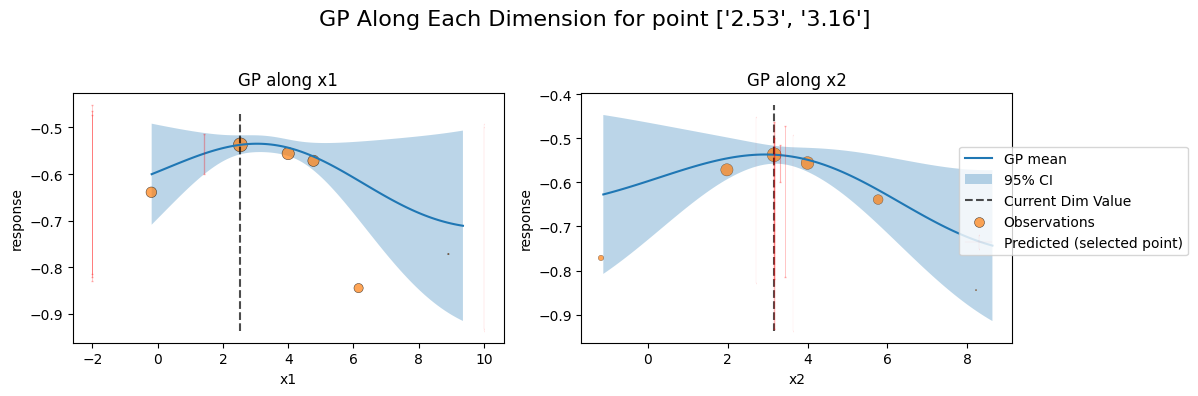

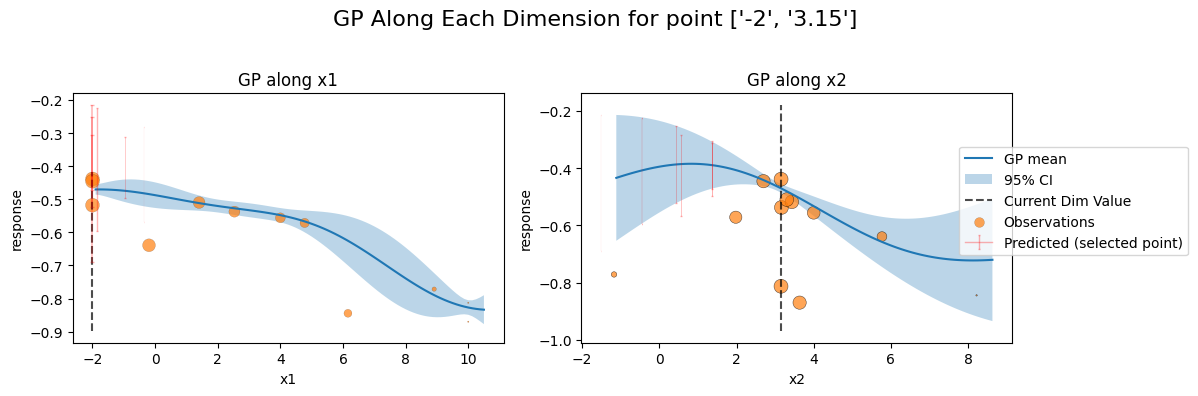

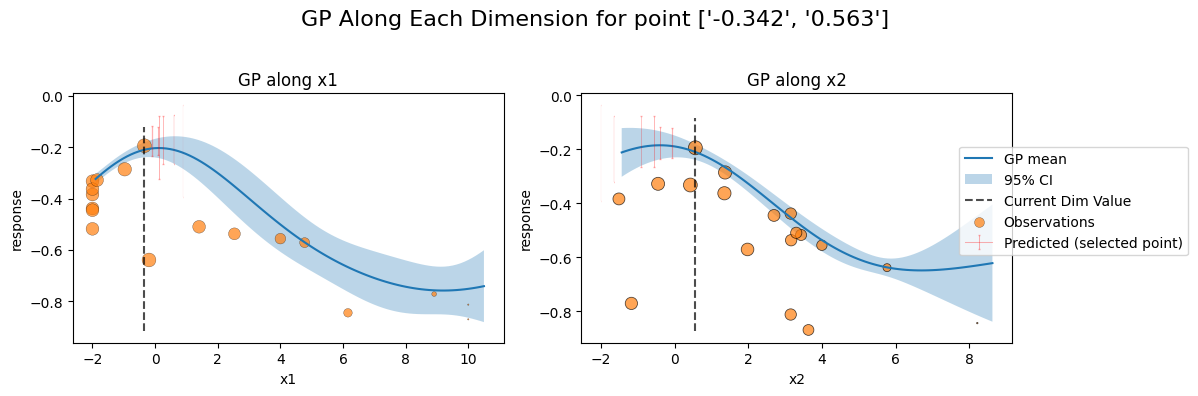

In [8]:
import matplotlib.pyplot as plt
for _ in range(3):
    batch_handler.get_next_batch()

    batch_handler.plot_GP(SingleTaskGP, figsize=(12, 4))
    batch_handler.complete_all_pending()

In [9]:
obs

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,0.580873,6.135384,-0.682070
2,2_0,7.620716,-0.539832,-0.787757
3,3_0,5.573166,9.149573,-0.889147
4,4_0,2.300320,2.474357,-0.493036
5,5_0,3.226609,7.225462,-0.763189


# Technical repeats
Knowing that real biological data posses significant significant noise, the model has to be robust enough to handle technical repeats

In [10]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1"]

def test_function(x1):
    # Original: y = -((x1 - 2) ** 2) + 10  -> range on [-2,10] is [-54, 10]
    y = -((x1 - 2) ** 2) + 10
    return (y + 54) / 64  # scale to [0,1]


noise_fn = lambda x: x + np.random.normal(0, 1)

def plot_test():
    plt.plot(np.linspace(-2, 10, 100), [test_function(x) for x in np.linspace(-2, 10, 100)], color='black', label='True function')

[INFO 09-23 12:14:33] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 12:14:33] ax.api.client: Generated new trial 1 with parameters {'x1': 3.211954} using GenerationNode Sobol.
[INFO 09-23 12:14:33] ax.api.client: Generated new trial 2 with parameters {'x1': 8.238779} using GenerationNode Sobol.
[INFO 09-23 12:14:33] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-23 12:14:33] ax.api.client: Trial 3 marked COMPLETED.
[INFO 09-23 12:14:33] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-23 12:14:33] ax.api.client: Trial 4 marked COMPLETED.
[INFO 09-23 12:14:33] ax.api.client: Trial 2 marked COMPLETED.
[INFO 09-23 12:14:33] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-23 12:14:34] ax.api.client: Generated new trial 6 with parameters {'x1': 5.730454} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-23 12:14:34] ax.api.client: Generated new trial 7 with parameters {'x1': -2.0} using Generati

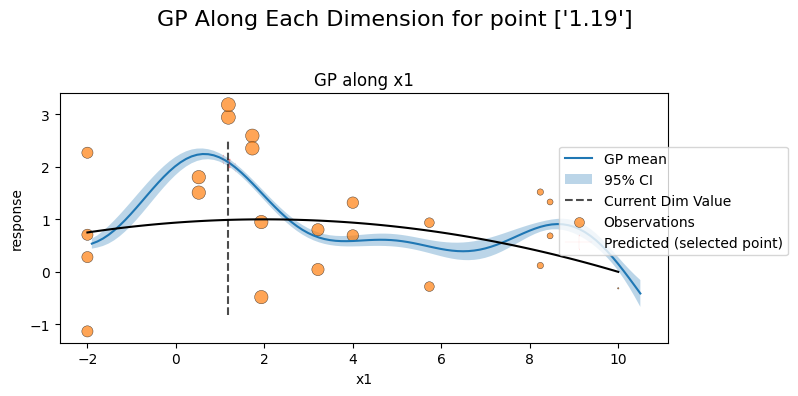

In [11]:
def sequential_runs(gp, acqf_class=qLogExpectedImprovement, n_runs=10, batch_size=1, technical_repeats=1,  noise_fn=None, plot_each = False):
    """Handles Simulating batch experiments sequentially."""
    client = Client()
    client.configure_experiment(parameters=range_parameters)
    client.configure_optimization(objective=metric_name)

    if noise_fn is None:
        noise_fn = lambda x: x

    generation_strategy = get_full_strategy(gp=gp, acqf_class=acqf_class)

    client.set_generation_strategy(
        generation_strategy=generation_strategy)

    handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=batch_size, range_params=range_parameters)
    handler.get_next_batch(batch_size)

    for _ in range(n_runs):
        handler.comp_noise_and_repeats(noise_fn=noise_fn, repeats=technical_repeats)
        handler.get_next_batch()
        if plot_each:
            handler.plot_GP(gp, figsize=(8, 4))
            plot_test()
            plt.show()
    return handler


runs = sequential_runs(SingleTaskGP, n_runs=4, technical_repeats=2, batch_size=3, noise_fn=noise_fn, plot_each=False)
runs.plot_GP(SingleTaskGP, figsize=(8, 4))
plot_test()

* This simple Kernel is incapable of encompassing noise. Consequently, it overfits.
* Technical repeats slightly improve the situation, however they do not fix the problem.

### GP + noise

Simply adding a lot of noise, significantly improves the fit.
 

[INFO 09-23 12:16:03] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 12:16:03] ax.api.client: Generated new trial 1 with parameters {'x1': 4.476775} using GenerationNode Sobol.
[INFO 09-23 12:16:03] ax.api.client: Generated new trial 2 with parameters {'x1': -1.015248} using GenerationNode Sobol.


[INFO 09-23 12:16:03] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-23 12:16:03] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-23 12:16:03] ax.api.client: Trial 2 marked COMPLETED.
[INFO 09-23 12:16:03] ax.api.client: Generated new trial 3 with parameters {'x1': 1.23778} using GenerationNode Sobol.
[INFO 09-23 12:16:03] ax.api.client: Generated new trial 4 with parameters {'x1': 8.229608} using GenerationNode Sobol.
[INFO 09-23 12:16:03] ax.api.client: Generated new trial 5 with parameters {'x1': 8.753797} using GenerationNode Sobol.
[INFO 09-23 12:16:03] ax.api.client: Trial 3 marked COMPLETED.
[INFO 09-23 12:16:03] ax.api.client: Trial 4 marked COMPLETED.
[INFO 09-23 12:16:03] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-23 12:16:04] ax.api.client: Generated new trial 6 with parameters {'x1': 1.612705} using GenerationNode GammaNoiseSGP+qLogExpectedImprovement.
[INFO 09-23 12:16:04] ax.api.client: Generated new trial 7 with parameters {'x1': 0.870554} using GenerationNod

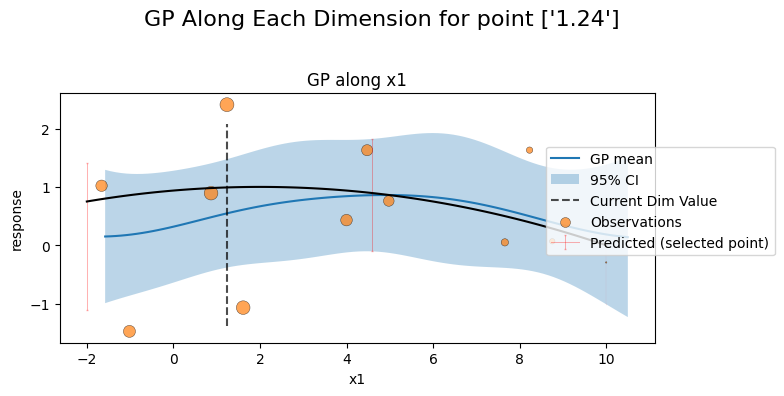

In [19]:
class GammaNoiseSGP(SingleTaskGP):
    """Just add a lot of assumed noise"""

    def __init__(
        self,
        train_X,
        train_Y,
        noise_concentration: float = 10,
        noise_rate: float = 10,
    ):

        likelihood = GaussianLikelihood(
            noise_prior=GammaPrior(noise_concentration, noise_rate)
        )

        super().__init__(
            train_X=train_X,
            train_Y=train_Y,
            likelihood=likelihood,
        )

runs = sequential_runs(GammaNoiseSGP, n_runs=4, technical_repeats=1, batch_size=3, noise_fn=noise_fn, plot_each=False)
runs.plot_GP(GammaNoiseSGP, figsize=(8, 4))
plot_test()

* Introducing a noise channel significantly improves fit performance, even if no technical repeats are provided to narrow down the mean.
However,a heteroscedastic, or at least technical repeat aware noise kernel would be preferable.

[INFO 09-23 12:16:12] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-23 12:16:12] ax.api.client: Generated new trial 1 with parameters {'x1': 8.55489} using GenerationNode Sobol.


[INFO 09-23 12:16:12] ax.api.client: Generated new trial 2 with parameters {'x1': 2.02792} using GenerationNode Sobol.
[INFO 09-23 12:16:12] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-23 12:16:12] ax.api.client: Trial 3 marked COMPLETED.
[INFO 09-23 12:16:12] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-23 12:16:12] ax.api.client: Trial 4 marked COMPLETED.
[INFO 09-23 12:16:12] ax.api.client: Trial 2 marked COMPLETED.
[INFO 09-23 12:16:12] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-23 12:16:14] ax.api.client: Generated new trial 6 with parameters {'x1': -2.0} using GenerationNode GammaNoiseSGP+qLogExpectedImprovement.
[INFO 09-23 12:16:14] ax.api.client: Generated new trial 7 with parameters {'x1': -0.959513} using GenerationNode GammaNoiseSGP+qLogExpectedImprovement.
[INFO 09-23 12:16:14] ax.api.client: Generated new trial 8 with parameters {'x1': 0.655215} using GenerationNode GammaNoiseSGP+qLogExpectedImprovement.
[INFO 09-23 12:16:14] ax.api.client: Trial 6 marke

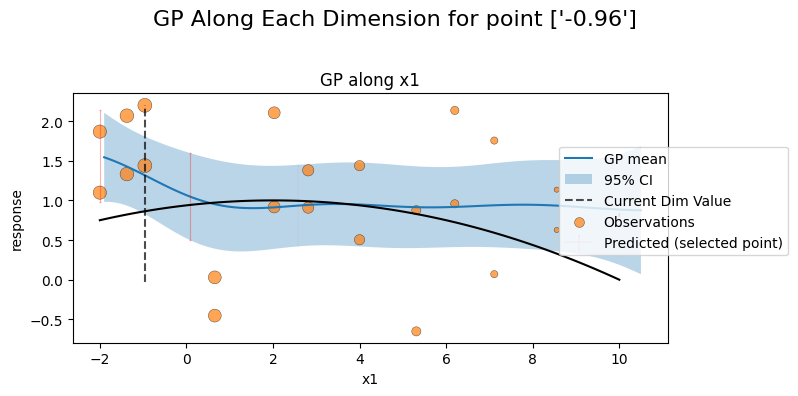

In [21]:
runs = sequential_runs(GammaNoiseSGP, n_runs=4, technical_repeats=2, batch_size=3, noise_fn=noise_fn, plot_each=False)
runs.plot_GP(GammaNoiseSGP, figsize=(8, 4))
plot_test()

It appears that technical repeats significantly improve noise resolution for the kernel, however, more quantitative tests are required.

# Quantification of Noise, technical repeats, and batch size.

In [23]:
obs = runs.get_batch_observations().sort_values(by='trial_index', ascending=True)
obs['y_true'] = obs['x1'].apply(test_function)
obs['error'] = obs['response'] - obs['y_true']
obs

,trial_name,x1,response,trial_index,y_true,error
0,0_0,4.000000,0.503695,0,0.937500,-0.433805
3,0_0,4.000000,1.438169,0,0.937500,0.500669
1,1_0,8.554890,0.626888,1,0.328647,0.298240
4,1_0,8.554890,1.135633,1,0.328647,0.806986
2,2_0,2.027920,0.916702,2,0.999988,-0.083286
5,2_0,2.027920,2.104681,2,0.999988,1.104693
6,6_0,-2.000000,1.097687,6,0.750000,0.347687
9,6_0,-2.000000,1.867454,6,0.750000,1.117454
7,7_0,-0.959513,1.438230,7,0.863145,0.575085
10,7_0,-0.959513,2.198722,7,0.863145,1.335577
